## 数据预处理与环境安装

In [1]:
# !pip install -q bnlearn

In [2]:
import pandas as pd

def process_csv_train(file_path):
    """
    处理训练数据，记录被删除的列、保留的列，并去除缺失值。
    """
    # 读取CSV文件
    df = pd.read_csv(file_path)
    
    # 去除缺失值
    df.dropna(inplace=True)
    
    removed_columns = []  # 用于记录被删除的列
    retained_columns = []  # 用于记录保留的列

    # 遍历每一列
    for col in df.columns:
        # 检查列中的所有值是否相同
        if df[col].nunique() == 1:
            # 如果所有值相同，删除该列并记录列名
            removed_columns.append(col)
            df.drop(col, axis=1, inplace=True)
        else:
            # 否则进行min-max归一化
            df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
            retained_columns.append(col)  # 记录保留的列

    return df, removed_columns, retained_columns


def process_csv_test(df_test, removed_columns, retained_columns, train_min_max, train_unique_values):
    """
    处理测试数据，删除与训练数据相同的列，并去除缺失值。
    过滤测试数据，确保每一行的所有列值都在训练数据中出现过。
    """
    # 去除缺失值
    df_test.dropna(inplace=True)

    # 删除训练数据中记录的列
    for col in removed_columns:
        if col in df_test.columns:  # 确保列存在
            df_test.drop(col, axis=1, inplace=True)

    # 对齐列顺序，确保测试数据与训练数据列一致
    df_test = df_test.reindex(columns=retained_columns)

    # 过滤测试数据，确保每一行的所有列值都在训练数据中出现过
    filtered_rows = []
    for _, row in df_test.iterrows():
        if all(row[col] in train_unique_values[col] for col in retained_columns):
            filtered_rows.append(row)
    
    # 构建过滤后的测试数据
    df_test_filtered = pd.DataFrame(filtered_rows, columns=retained_columns)

    # 对剩余列进行min-max归一化（使用训练数据的最小值和最大值）
    for col in df_test_filtered.columns:
        df_test_filtered[col] = (df_test_filtered[col] - train_min_max[col]['min']) / (train_min_max[col]['max'] - train_min_max[col]['min'])

    return df_test_filtered


# 处理训练数据并记录被删除的列和保留的列
train_df, removed_columns, retained_columns = process_csv_train('data_origin.csv')

# 获取训练数据的最小值、最大值和唯一值，用于测试数据归一化和过滤
train_min_max = {col: {'min': train_df[col].min(), 'max': train_df[col].max()} for col in train_df.columns}
train_unique_values = {col: set(train_df[col].unique()) for col in train_df.columns}

# 处理测试数据
test_df_abnormal = pd.read_csv('metrics_anomaly.csv')
test_df_normal = pd.read_csv('metrics_abnormal.csv')

# 使用相同的删除规则和归一化参数处理测试数据
test_df_abnormal_processed = process_csv_test(test_df_abnormal, removed_columns, retained_columns, train_min_max, train_unique_values)
test_df_normal_processed = process_csv_test(test_df_normal, removed_columns, retained_columns, train_min_max, train_unique_values)

# 给测试数据添加标签
test_df_normal_processed['label'] = 0  # 正常样本标记为 0
test_df_abnormal_processed['label'] = 1  # 异常样本标记为 1

# 合并两个测试集
test_df = pd.concat([test_df_normal_processed, test_df_abnormal_processed], axis=0).reset_index(drop=True)

## 相关性分析

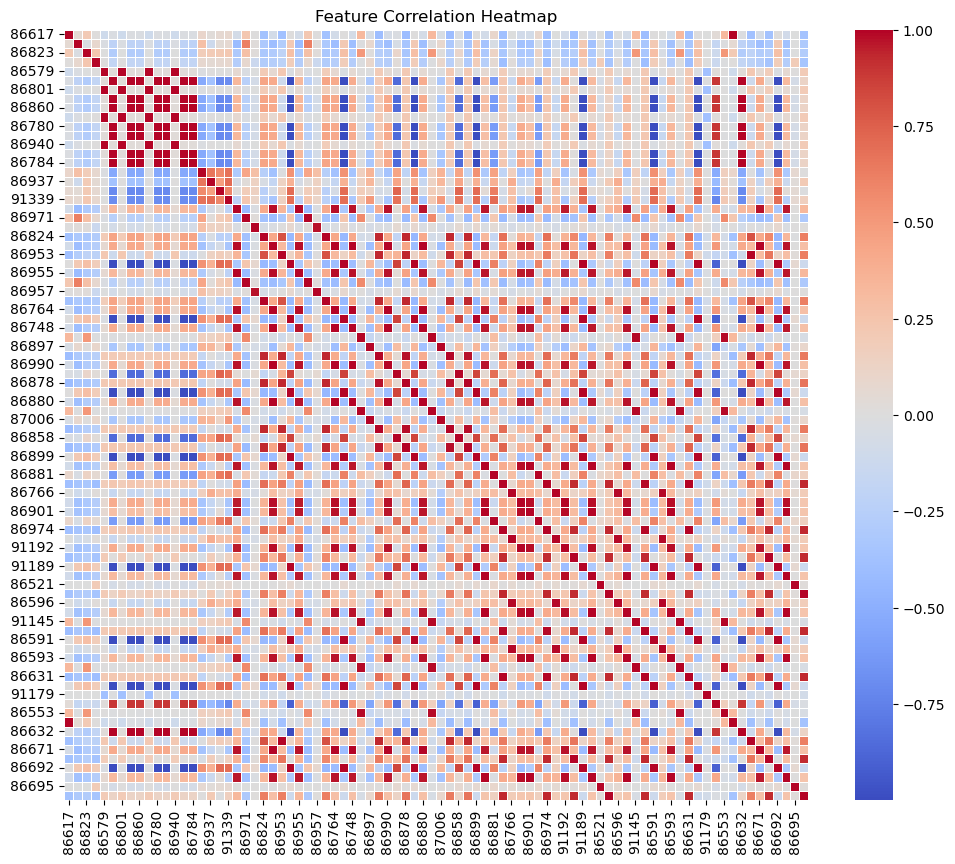

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算特征之间的相关性
correlation_matrix = train_df.corr()

# 画热力图（取消 annot）
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", linewidths=0.5, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()



## 训练贝叶斯网络

[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
[bnlearn] >Warning: [graphviz_layout] layout not found. The layout [spring_layout] is used instead.


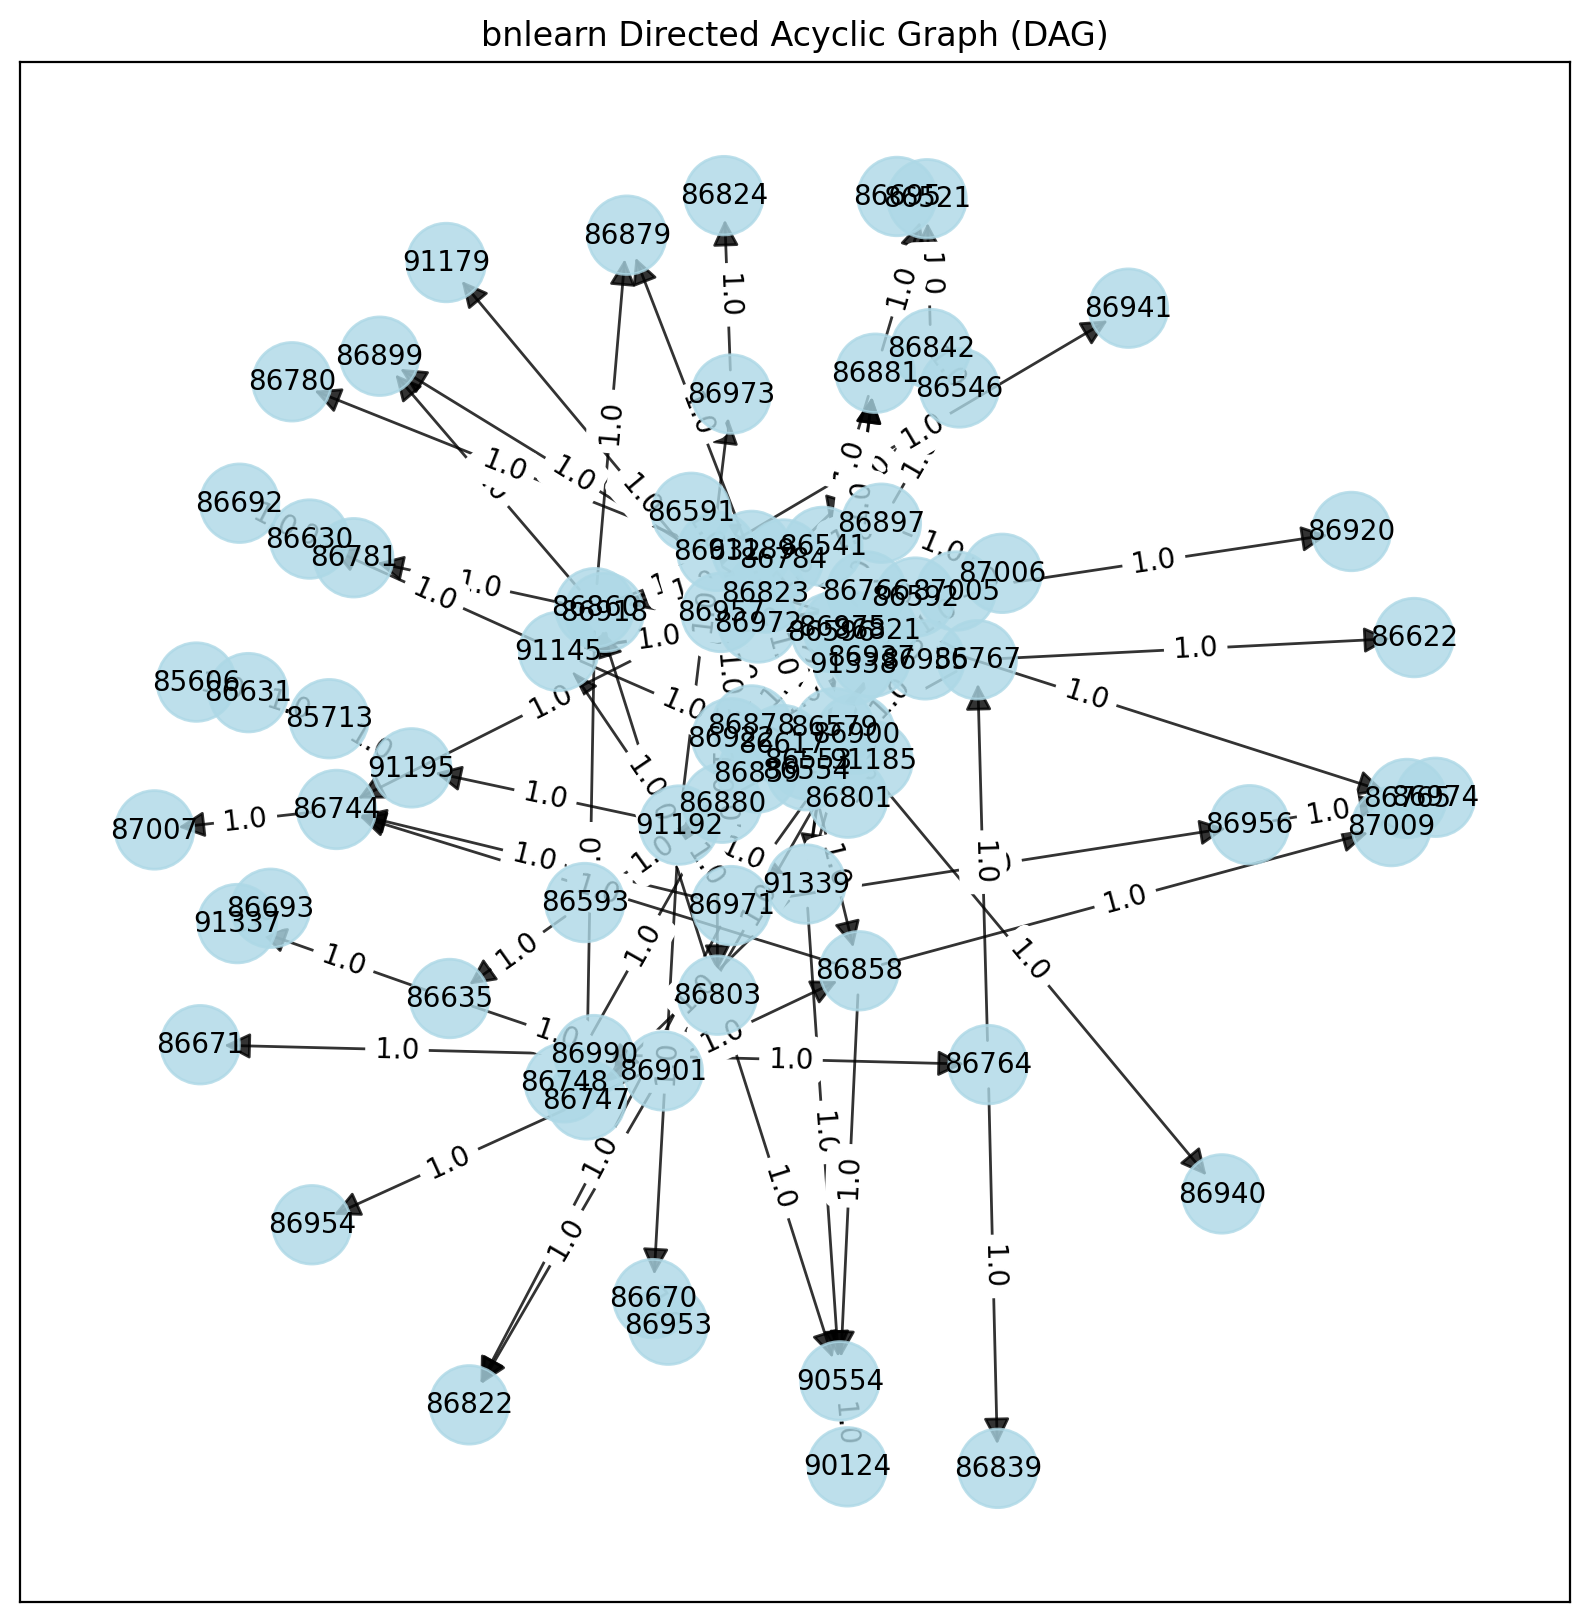

In [4]:
import bnlearn as bn

test_df_normal = test_df_normal.head(50)
test_df_abnormal = test_df_abnormal.head(50)
test_df = pd.concat([test_df_normal, test_df_abnormal], ignore_index=True)

def construct_bayesian_network(train_df):
    """构建贝叶斯网络"""
    # 结构学习
    model = bn.structure_learning.fit(train_df, methodtype='hc',verbose=0)
    # 参数学习
    model = bn.parameter_learning.fit(model, train_df,verbose=0)
    return model

# 训练贝叶斯网络
model = construct_bayesian_network(train_df)

import matplotlib.pyplot as plt

plt.ioff()  # 关闭交互模式，减少额外输出
bn.plot(model)
plt.show()  # 仅显示最终的图，而不会产生额外文本输出

## 异常检测与可视化

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score
def detect_anomalies(model, df, threshold=None):
    """使用贝叶斯网络计算对数似然，并检测异常"""
    log_likelihoods = []

    for i in range(len(df)):
        sample = df.iloc[i].to_dict()
        
        # 选择目标变量作为预测变量，而不是所有变量
        target_variable = list(sample.keys())[-1]  # 假设最后一列为目标变量
        evidence = {k: v for k, v in sample.items() if k != target_variable and k != 'label'}

        try:
            log_likelihood = bn.inference.fit(model, variables=[target_variable], evidence=evidence)
            log_likelihoods.append(log_likelihood)
        except Exception as e:
            print(f"⚠️ 计算第 {i} 行时发生错误: {e}")
            log_likelihoods.append(None)

    df['log_likelihood'] = log_likelihoods

    # 如果未指定阈值，则使用训练集对数似然的均值 - 3 * 标准差 作为阈值
    if threshold is None:
        threshold = np.nanmean(log_likelihoods) - 3 * np.nanstd(log_likelihoods)

    df['anomaly'] = df['log_likelihood'] < threshold  # 低于阈值的视为异常
    return df[['log_likelihood', 'anomaly']], threshold

# 计算训练集的对数似然分布，并确定异常阈值
train_results, threshold = detect_anomalies(model, train_df)

# 在测试集上检测异常
test_results, _ = detect_anomalies(model, test_df, threshold)

# 计算准确率
y_true = test_df['label'].values  # 真实标签
y_pred = test_results['anomaly'].astype(int).values  # 预测的异常值 (1: 异常, 0: 正常)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# 可视化结果
plt.figure(figsize=(10, 5))
plt.hist(train_results['log_likelihood'], bins=30, alpha=0.6, label="Train Log-Likelihood", color='blue')
plt.hist(test_results['log_likelihood'], bins=30, alpha=0.6, label="Test Log-Likelihood", color='orange')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label="Anomaly Threshold")
plt.xlabel("Log-Likelihood")
plt.ylabel("Frequency")
plt.title("Log-Likelihood Distribution (Train vs Test)")
plt.legend()
plt.show()

# 标记异常点
plt.figure(figsize=(8, 4))
plt.scatter(range(len(test_results)), test_results['log_likelihood'], c=test_results['anomaly'], cmap="coolwarm", edgecolors='k')
plt.axhline(threshold, color='red', linestyle='dashed', linewidth=2, label="Anomaly Threshold")
plt.xlabel("Sample Index")
plt.ylabel("Log-Likelihood")
plt.title("Anomaly Detection in Test Data")
plt.legend()
plt.show()

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-----------+-------------+
|    |     90124 |           p |
+====+===========+=============+
|  0 | 0         | 7.11878e-05 |
+----+-----------+-------------+
|  1 | 0.027027  | 7.11878e-05 |
+----+-----------+-------------+
|  2 | 0.0540541 | 7.11878e-05 |
+----+-----------+-------------+
|  3 | 0.0810811 | 7.11878e-05 |
+----+-----------+-------------+
|  4 | 0.108108  | 7.11878e-05 |
+----+-----------+-------------+
|  5 | 0.135135  | 7.11878e-05 |
+----+-----------+-------------+
|  6 | 0.162162  | 7.11878e-05 |
+----+-----------+-------------+
|  7 | 0.189189  | 7.11878e-05 |
+----+-----------+-------------+
|  8 | 0.216216  | 7.11878e-05 |
+----+-----------+-------------+
|  9 | 0.243243  | 7.11878e-05 |
+----+-----------+-------------+
| 10 | 0.27027   | 7.11878e-05 |
+----+-----------+-------------+
| 11 | 0.297297  | 7.11878e-05 |
+----+